In [1]:
from PIL import Image, ImageOps
import requests
from functools import reduce

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# this time, each image is rgb and 32*32. My inputs will be N*3*32*32 where N is batch size
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, scale=(0.8, 1.2), shear=10 ),
    transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# ImageFolder is used to load images from a folder. In my train and val folders, i create an ants folder and a bees folder. Pytorch understands that each folder is associated to a different label
classes = ("ant", "bee")

training_dataset = datasets.ImageFolder(root="./data/ants_and_bees/train", transform=transform_train) 
validation_dataset = datasets.ImageFolder(root="./data/ants_and_bees/val", transform=transform)
training_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size=20, shuffle=True) 
validation_loader = torch.utils.data.DataLoader(dataset = validation_dataset, batch_size=20, shuffle=False)

In [2]:
img_as_array = np.array(Image.open(training_loader.dataset.imgs[0][0]))
img_as_array.shape, img_as_array.min(), img_as_array.max()

((512, 768, 3), 0, 255)

In [3]:
ins, labs = next(iter(training_loader))
ins.shape, ins.min(), ins.max()

(torch.Size([20, 3, 224, 224]), tensor(-1.), tensor(1.))

In [4]:
ins[0].shape, ins[0].min(), ins[0].max()

(torch.Size([3, 224, 224]), tensor(-0.6392), tensor(0.4039))

In [5]:

print( "Dans le dataset, les valeurs des pixels vont de", ins[0].min(), "à", ins[0].max())

Dans le dataset, les valeurs des pixels vont de tensor(-0.6392) à tensor(0.4039)


In [6]:
# small dataset so we use transfer learning
len(training_dataset), len(validation_dataset)

(244, 153)

In [7]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy() #3*28*28
    image = image.transpose(1,2,0) #28*28*3 
    image = image * np.array([0.5])+ np.array([0.5]) #reverse normalisation
    image.clip(0,1) #ensures range is between 0 and 1
    return image
def img_transform(img):
    img = Image.open(img)
    img = transform(img) # apply the transform defined on top
    return img

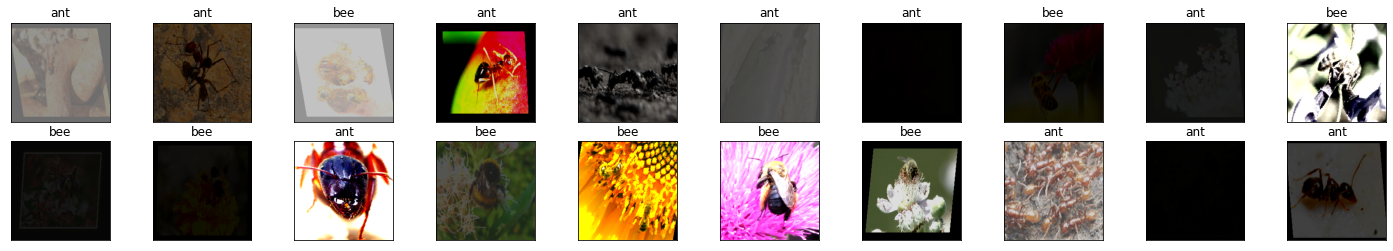

In [8]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2,10, idx+1, xticks=[], yticks= [])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

In [9]:
# we load our pretrained model
# model = models.alexnet(pretrained=True)
model = models.vgg16(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
# https://debuggercafe.com/visualizing-filters-and-feature-maps-in-convolutional-neural-networks-using-pytorch/
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list
 
# get all the model children as list
model_children = list(model.children())

# counter to keep count of the conv layers
counter = 0 

# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for child in model_children[i].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 13


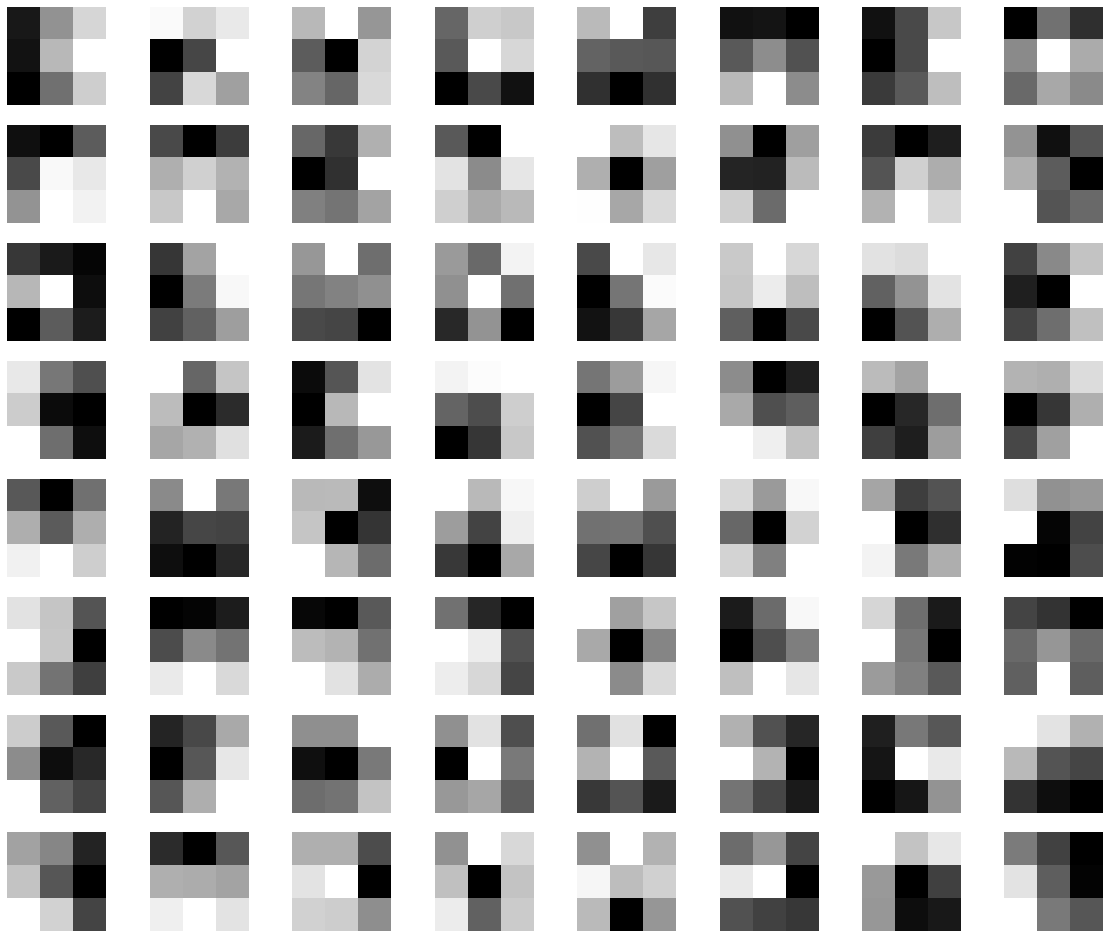

In [11]:
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
model.parameters()
plt.show()

In [12]:
# we freeze the features parameters
for param in model.features.parameters():
    param.requires_grad = False

In [13]:
# we need to change the final output layer in the classifier because we only have two classes
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))

model.classifier[6] = last_layer
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

61%|██████    | 61/100 [00:22<00:14,  2.70it/s]Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()



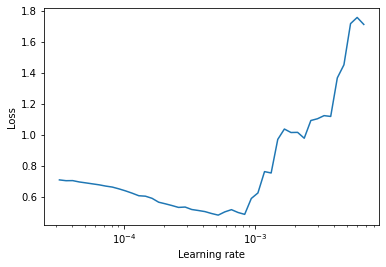

In [14]:
from torch_lr_finder import LRFinder
model = model.to(device) # model is on gpu
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr =10e-3) # we slow down the lr because we have a small dataset
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(training_loader, start_lr=1e-5,end_lr=1, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [15]:
epochs = 10
nb_iterations = len(training_loader) * epochs
pct_start = 0.7
step_size_up = int(pct_start * nb_iterations)
step_size_down = int((1-pct_start) * nb_iterations)
step_size_down += nb_iterations - (step_size_up + step_size_down)

In [16]:
lr = 3e-4

optimizer = torch.optim.SGD(model.parameters(), lr =lr, momentum=0.9) # we slow down the lr because we have a small dataset
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=lr/10, max_lr=lr, step_size_up=step_size_up, step_size_down=step_size_down)
optimizer.defaults

{'lr': 0.0003,
 'momentum': 0.9,
 'dampening': 0,
 'weight_decay': 0,
 'nesterov': False}

In [17]:
#because the feature part has requires_grad set to false, the training will only change the classifier part

model = model.to(device) # model is on gpu
current_lr = []
current_momentum = []


running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for i in range(epochs):

    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in training_loader: #les inputs sont de dimension 100 * 3* 32 * 32 (100 mesures, 3 channels, 32*32 pixels)

        for param_group in optimizer.param_groups:
            current_lr.append(param_group["lr"])
            current_momentum.append(param_group["momentum"])

        inputs = inputs.to(device) # use gpu
        labels = labels.to(device)

       
        outputs = model(inputs) #no more forward or dropout
        loss = criterion(outputs, labels) # see docs, it is normal, input is raw score and labels is class number of target
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        scheduler.step()

        _, preds = torch.max(outputs,1) #preds is the index of the max value for the 100 images

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels)
    else:
    #runs after for loop ends
        with torch.no_grad():
            model.eval()
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                _, val_preds = torch.max(val_outputs,1) #preds is the index of the max value for the 100 images
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels)
        model.train()



    epoch_loss = running_loss/len(training_loader) 
    epoch_acc = running_corrects/len(training_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    print("training loss: {:4f}, accuracy : {:4f}".format(epoch_loss, epoch_acc.item()))

    val_epoch_loss = val_running_loss/len(validation_loader) 
    val_epoch_acc = val_running_corrects/len(validation_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print("validation loss: {:4f}, accuracy : {:4f}".format(val_epoch_loss, val_epoch_acc.item()))

training loss: 0.700806, accuracy : 0.553279
validation loss: 0.626643, accuracy : 0.666667
training loss: 0.651727, accuracy : 0.602459
validation loss: 0.521554, accuracy : 0.810458
training loss: 0.523305, accuracy : 0.758197
validation loss: 0.433956, accuracy : 0.862745
training loss: 0.542529, accuracy : 0.696721
validation loss: 0.369809, accuracy : 0.882353
training loss: 0.463922, accuracy : 0.795082
validation loss: 0.323486, accuracy : 0.895425
training loss: 0.428532, accuracy : 0.811475
validation loss: 0.291482, accuracy : 0.921569
training loss: 0.420145, accuracy : 0.823770
validation loss: 0.266220, accuracy : 0.928105
training loss: 0.369716, accuracy : 0.831967
validation loss: 0.248392, accuracy : 0.934641
training loss: 0.396773, accuracy : 0.811475
validation loss: 0.236289, accuracy : 0.934641
training loss: 0.351960, accuracy : 0.827869
validation loss: 0.232521, accuracy : 0.934641


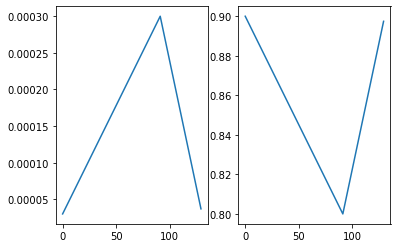

In [52]:
plt.subplot(1,2,1)
plt.plot(current_lr)
plt.subplot(1,2,2)
plt.plot(current_momentum)

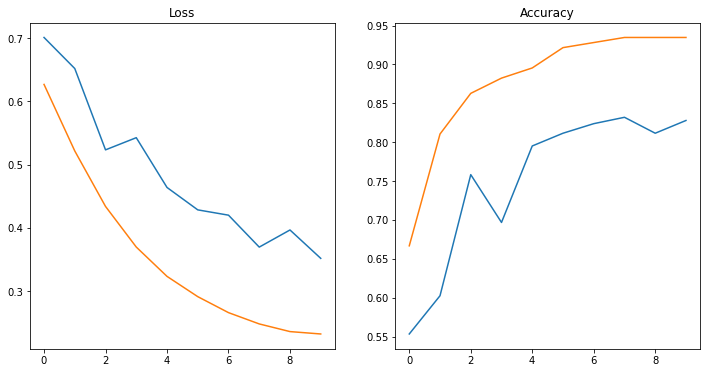

In [53]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Loss")
plt.plot(running_loss_history, label="training loss")
plt.plot(val_running_loss_history, label="validation loss")
plt.subplot(1,2,2)
plt.title("Accuracy")
plt.plot(running_corrects_history, label="training accuracy")
plt.plot(val_running_corrects_history, label="validation accuracy")

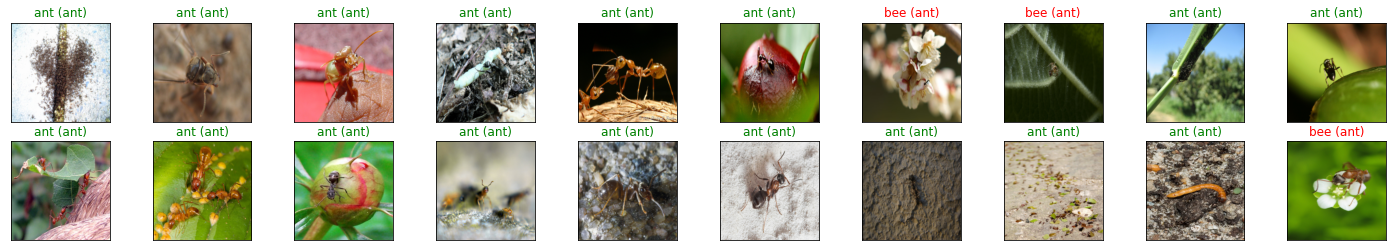

In [20]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
outputs = model.forward(images)
_, preds = torch.max(outputs,1)
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2,10,idx + 1, xticks = [], yticks = [])
    plt.imshow(im_convert(images[idx]), cmap="gray")
    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]== labels[idx] else "red"))

<Response [200]>


'bee'

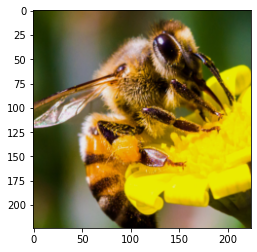

In [21]:
url = "https://i.guim.co.uk/img/media/9988a21ff2c14703e6be54cf00b584b86764d672/945_1419_3421_2052/master/3421.jpg?width=1200&height=1200&quality=85&auto=format&fit=crop&s=2bd4eef1cafae3ff1bd758581cd4afff"
response = requests.get(url, stream=True)
print(response)
img = img_transform(response.raw)
plt.imshow(im_convert(img))
scores = model.forward(img.unsqueeze(0).to(device)) # unsqueeze to add a dim, to device to use gpu
_,  pred = torch.max(scores,1)
classes[pred]

<Response [200]>


'ant'

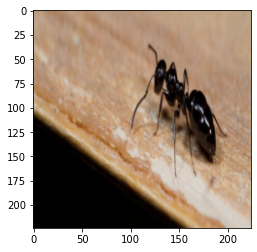

In [22]:
url = "https://cdn.rentokil.com/content/local/id/images/desktop/main_img_banner-ants-rentokil-indonesia.jpg"
response = requests.get(url, stream=True)
print(response)
img = img_transform(response.raw)
plt.imshow(im_convert(img))
scores = model.forward(img.unsqueeze(0).to(device)) # unsqueeze to add a dim, to device to use gpu
_,  pred = torch.max(scores,1)
classes[pred]